# The harmonic function method and the mass of some Schwarzschild half-spaces - Computations and Graphs

In this Jupyter Notebook, we will do two main things for our examples from Section 8:
- Compute the lower bound given by Theorem 3.9
- Plot the level sets of the harmonic coordinates

### Setting up the Python environment

In [49]:
# This file is present both as .ipynb as well as .py. For the latter, the `# %%` comment denote borders between cells so the Python file can be treated like an Jupyter notebook as well. The function below checks if the Python file is running inside a Jupyter Notebook
def is_notebook() -> bool:
  try:
    shell = get_ipython().__class__.__name__ # type: ignore[reportUndefinedVariable]
    if shell in ('ZMQInteractiveShell','XPythonShell'):
        return True   # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
        return False  # Terminal running IPython
    else:
        return False  # Other type (?)
  except NameError:
    return False      # Probably standard Python interpreter

In [50]:
if is_notebook():
  get_ipython().run_line_magic("pip", "install gravipy matplotlib scikit-image") # this helps if this Notebook is executed from within e.g. jupyter-cloud.gwdg.de  # type: ignore[reportUndefinedVariable]

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from gravipy.tensorial import * # import GraviPy package
import sympy
import numpy as np
import scipy
import matplotlib.pyplot as plt

# for plotting of implicit surfaces (i.e. the level sets)
from mpl_toolkits.mplot3d import axes3d
from skimage import measure

from sympy.utilities.lambdify import lambdastr

In [52]:
if is_notebook():
  from IPython.display import display, Markdown
else:
  from rich.markdown import Markdown
  from rich.console import Console
  console = Console()
  display = console.print


### Setting up the manifold, metric, etc.

In [53]:
x1,x2 = symbols("x_1 x_2", real=True)
x3 = symbols("x_3", nonnegative=True)
m = symbols("m",positive=True)

coords=[x1,x2,x3]
pos = Coordinates(r'\chi',[x1,x2,x3])
R=sympy.sqrt(x1**2+x2**2+x3**2)
omega=(1+m/(2*R))
# metric = sympy.MatrixSymbol("g",3,3)
metric = omega**4*sympy.eye(3)
g = MetricTensor('g', pos, metric)
Ga = Christoffel(r'\Gamma', g)

In [54]:
# metric of hypersurface
gamma_metric = omega**4*sympy.diag(0,1,1)
gamma = MetricTensor(r'\gamma', pos, gamma_metric)
Ga_gamma = Christoffel(r'\Gamma_{\gamma}',gamma)

Some utility functions:

In [55]:
def laplacian(scalar):
  return sum([g(-i,-j)*scalar.covariantD(i,j) for i in range(1,4) for j in range(1,4)])

In [56]:
def gradient(symbol):
  V = Tensor(r"\Nabla "+str(symbol),1,g)
  def compute_V(idxs):
    component=sympy.diff(symbol,coords[idxs[0]-1])
    V.components.update({idxs:component})
    return component
  V._compute_contravariant_component=compute_V
  return V

### Setting up the harmonic coordinates

Define all the harmonic coordinates for $M_{m,+}$:

In [57]:
u1,u2,u3 = [Tensor(f"u_{i}",0,g) for i in range(1,4)]
harmonic_coords = [u1,u2,u3]

def make_u_method(x,u):
  def u_method(idxs):
    component = x*(1+m**3 / (8 * R**3))/omega
    u.components.update({idxs: component})
    return component
  return u_method

for x, u in zip(coords,harmonic_coords):
  u._compute_covariant_component = make_u_method(x,u)

And define $u_3$ for the modified Schwarzschild space $M_{m,\geq a}$ for $a>0$:

In [58]:
a = symbols("a")
u3_modified = Tensor("u_3",0,g)

def u3_modified_method(idxs):
    component = (x3+m*a/(2*R))/omega
    u3_modified.components.update({idxs: component})
    return component
u3_modified._compute_covariant_component = u3_modified_method

Are our functions truly harmonic?

In [59]:
print("Harmonicity check:")
for i,u in enumerate(harmonic_coords):
  display(Markdown(f"$\Delta u_{i+1}={laplacian(u).simplify()}$"))

Harmonicity check:


$\Delta u_1=0$

$\Delta u_2=0$

$\Delta u_3=0$

In [60]:
display(Markdown(f"For $M_{{m,\geq a}}$: $\Delta u_3={laplacian(u3_modified).simplify()}$"))

For $M_{m,\geq a}$: $\Delta u_3=0$

### Are there any critical points?

It is interesting to consider whether there are any critical points of $u_3$ to be able to discuss how strong the lower bound given by our technique is (see Remark 4.3).

##### For $M_{m,+}$ there is at least one (at (0,0,m/2)):

In [61]:
display(Markdown(f"On $M_{{m,+}}$, there is at least one critical point: At $(0,0,m/2)$ we have $\operatorname{{grad}} u={sympy.latex(sympy.Array([u3.covariantD(i) for i in range(1,4)]).subs(((x1,0),(x2,0),(x3,m/2))))}$"))

On $M_{m,+}$, there is at least one critical point: At $(0,0,m/2)$ we have $\operatorname{grad} u=\left[\begin{matrix}0 & 0 & 0\end{matrix}\right]$

##### For $M_{m,\geq a}$:

In [62]:
relevant_derivative = u3_modified.covariantD(3).simplify()
only_numerator = sympy.fraction(relevant_derivative)[0].expand()
display(Markdown(f"""On $M_{{m,\geq a}} (for $a>0$), $u_3$ has no critical points! 
                 
It suffices to look at the derivative in $x_3$-direction, which is always positive: We have $\partial_3 u_3={sympy.latex(relevant_derivative)}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator ${sympy.latex(only_numerator)}$.

But $x_3\geq a > 0$ and thus $-2amx_3|x|+4m x_3^2|x| > 0$, and thus we have $\partial_3 u_3>0$."""))

On $M_{m,\geq a} (for $a>0$), $u_3$ has no critical points! 
                 
It suffices to look at the derivative in $x_3$-direction, which is always positive: We have $\partial_3 u_3=\frac{m x_{3} \left(a m + 2 x_{3} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right) - \left(m + 2 \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right) \left(a m x_{3} - 2 \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{\frac{3}{2}}\right)}{\left(m + 2 \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator $- 2 a m x_{3} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2 m x_{1}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2 m x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4 m x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4 x_{1}^{4} + 8 x_{1}^{2} x_{2}^{2} + 8 x_{1}^{2} x_{3}^{2} + 4 x_{2}^{4} + 8 x_{2}^{2} x_{3}^{2} + 4 x_{3}^{4}$.

But $x_3\geq a > 0$ and thus $-2amx_3|x|+4m x_3^2|x| > 0$, and thus we have $\partial_3 u_3>0$.

## Computation of the lower bound

Let's try to compute the lower bound for the mass. We avoid simplifying anything (I once tried to let `sympy` simplify `abs_hessian_u3`, and it did complete, but only after 10 hours!). Even with manual help factoring out $\omega$ terms and the like, the computation times are still often in the minutes. The numerical integration later on is fast enough to deal with unoptimized expressions.

In [63]:
abs_nabla_u3=sympy.sqrt(sum(g(-i,-j)*u3.covariantD(i)*u3.covariantD(j) for i in range(1,4) for j in range(1,4)))

In [64]:
abs_nabla_u3_modified=sympy.sqrt(sum(g(-i,-j)*u3_modified.covariantD(i)*u3_modified.covariantD(j) for i in range(1,4) for j in range(1,4)))

In [65]:
abs_hessian_u3=sympy.sqrt(sum(g(-i,-k)*g(-j,-l)*u3.covariantD(i,j)*u3.covariantD(k,l) for i,j,k,l in list(variations(range(1, 4), 4, True))))

In [66]:
abs_hessian_u3_modified=sympy.sqrt(sum(g(-i,-k)*g(-j,-l)*u3_modified.covariantD(i,j)*u3_modified.covariantD(k,l) for i,j,k,l in variations(range(1, 4), 4, True)))

We can now express the integrands. Note that we need to include the volume element. Also we have $R=0$, so the second term in the integrand disappears

In [67]:
lower_bound_integrand_over_M=1/(16*sympy.pi)*(abs_hessian_u3**2/abs_nabla_u3)*omega**6
lower_bound_modified_integrand_over_M=1/(16*sympy.pi)*(abs_hessian_u3_modified**2/abs_nabla_u3_modified)*omega**6

For the boundary term we first compute the mean curvature (observe that the result agrees with our computation in Section 8)

In [68]:
normal_vector_to_noncompact_boundary = Tensor(r"\nu",1,g)
def nu_compute_covariant_component(idxs):
  if idxs[0]==3:
    component = -omega**2
  else:
    component = sympy.Number(0)
  normal_vector_to_noncompact_boundary.components.update({idxs:component})
  return component
normal_vector_to_noncompact_boundary._compute_covariant_component=nu_compute_covariant_component

In [69]:
H=sum(g(-i,-j)*normal_vector_to_noncompact_boundary.covariantD(i,j) for i,j in variations(range(1,4),2,True))
display(Markdown(f"Mean curvature $H$ of non-compact boundary is ${sympy.latex(H.simplify())}$, which is the same as $\\frac{{2m}}{{{{|x|}}^3\\cdot \omega^3}}x_3={sympy.latex(2*m*x3/(R**3*omega**3).simplify())}$."))

Mean curvature $H$ of non-compact boundary is $\frac{16 m x_{3}}{\left(m + 2 \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{3}}$, which is the same as $\frac{2m}{{|x|}^3\cdot \omega^3}x_3=\frac{16 m x_{3}}{\left(m + 2 \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{3}}$.

The above is greater than $0$ in particular if $x_3>0$. We can now also write down the expression for integral term on the boundary (we need to use the volume element of $\Sigma$ here). Note that the integrand over the boundary vanishes for $M_{m,+}$.

In [70]:
lower_bound_integrand_over_boundary = 1/(8*sympy.pi)*(H.subs(x3,0).simplify()*abs_nabla_u3)*omega**4
print(f"{lower_bound_integrand_over_boundary=}")

lower_bound_modified_integrand_over_boundary = 1/(8*sympy.pi)*(H.subs(x3,a).simplify()*abs_nabla_u3_modified)*omega**4

lower_bound_integrand_over_boundary=0


We use `sympy.lambdify` to get numerical expressions for our integrands. We set $m=1$ and $a=2$ for now.

In [71]:
# numerical implementation
num_lower_bound_integrand_over_M = sympy.lambdify([x1,x2,x3,m],lower_bound_integrand_over_M)
num_lower_bound_integrand_over_boundary = sympy.lambdify([x1,x2,x3,m],lower_bound_integrand_over_boundary)

num_lower_bound_modified_integrand_over_M = sympy.lambdify([x1,x2,x3,m,a],lower_bound_modified_integrand_over_M)
num_lower_bound_modified_integrand_over_boundary = sympy.lambdify([x1,x2,x3,m,a],lower_bound_modified_integrand_over_boundary)


We can now do the numerical integration. Due to symmetry we are able to only integrate over one quadrant ($x_1\geq 0$, $x_2\geq 0$ in addition to the usual $x_3\geq 0$) and multiply by 4 afterwards.

In [72]:
min_radius = lambda mass: mass/2


x3range=lambda mass:[0,np.inf]
x2range=lambda x3_value,mass: [np.sqrt(max(min_radius(mass)**2-x3_value**2,0)),np.inf]
x1range=lambda x3_value,x2_value,mass: [np.sqrt(max(min_radius(mass)**2-x2_value**2-x3_value**2,0)),np.inf]

m_value=1


The integrand explodes near the intersection of the $x_3$-axis and the horizon, and thus convergence of the numerical integration is slow. To raise speed and lower accuracy, we can lower the `limit` parameter (for limiting the numbers of subintervals used in the algorithm). The default is 50 but takes forever, but already a value of 1 gives errors small enough for the result to be useful to us. With a limit of 2 the integration already takes three minutes on my machine and has only slightly better accuracy.

In [73]:
result = scipy.integrate.nquad(
  func=num_lower_bound_integrand_over_M,
  ranges=[x1range,x2range,x3range],
  args=[m_value], # passed to all functions in addition to coordinates
  full_output=True,
  opts={"limit":1}
)

# we do not need to do the integral over the boundary here, since the integrand is 0

In [74]:
schwarzschild_half_space_mass_lower_bound = 4*result[0]
error_estimate = 4*result[1]
number_evaluations = result[2]['neval']
display(Markdown(f"## Lower bound for mass (expected $m/2={m_value}/2$) of $M_{{{m_value},+}}$ calculated in ${number_evaluations}$ evaluations as ${schwarzschild_half_space_mass_lower_bound:.5f}$ with an estimated absolute error of ${error_estimate:.5f}$."))

## Lower bound for mass (expected $m/2=1/2$) of $M_{1,+}$ calculated in $3375$ evaluations as $0.32473$ with an estimated absolute error of $0.14097$.

We can now do the same process for $M_{m,\geq a}$ for $a>0$:

In [75]:
modified_x3range=lambda m_num,a_num:[a_num,np.inf]
modified_x2range=lambda x3_num,m_num,a_num: [0,np.inf]
modified_x1range=lambda x3_num,x2_num,m_num,a_num: [0,np.inf]

modified_x2_boundary_range = [0,np.inf]
modified_x1_boundary_range = [0,np.inf]

a_value = 10


We have the same problem as before and need to limit the number of subintervals

In [76]:
result_on_M = scipy.integrate.nquad(
  func=num_lower_bound_modified_integrand_over_M,
  ranges=[modified_x1range,modified_x2range,modified_x3range],
  args=[m_value,a_value],
  full_output=True,
  opts={"limit":1}
)

But on the boundary, the numerical integration converges nicely

In [77]:
result_on_boundary = scipy.integrate.nquad(
  func=num_lower_bound_modified_integrand_over_boundary,
  ranges=[modified_x1_boundary_range,modified_x2_boundary_range],
  args=[a_value,m_value,a_value], # we also need to pass x_3=a here
  full_output=True,
  opts={"limit":20}
)

In [78]:
modified_schwarzschild_half_space_mass_lower_bound = 4*result_on_M[0]+4*result_on_boundary[0]
error_estimate_modified = 4*result_on_M[1]+4*result_on_boundary[1]
number_evaluations_modified = result_on_M[2]['neval'] + result_on_boundary[2]['neval'] # most of these will come from the boundary integral where we set the `limit` parameter higher
display(Markdown(f"## Lower bound for mass $m={m_value}$ of $M_{{m,\geq {a_value}}}$ calculated in ${number_evaluations}$ evaluations as ${modified_schwarzschild_half_space_mass_lower_bound:.5f}$ with an estimated absolute error of ${error_estimate:.5f}$."))

## Lower bound for mass $m=1$ of $M_{m,\geq 10}$ calculated in $3375$ evaluations as $0.50161$ with an estimated absolute error of $0.14097$.

We can repeat this calculation for different values of $a$ and plot the results:

In [79]:
def calculate_lower_bound_modified(a_value,m_value):
  result_on_M = scipy.integrate.nquad(
    func=num_lower_bound_modified_integrand_over_M,
    ranges=[modified_x1range,modified_x2range,modified_x3range],
    args=[m_value,a_value],
    full_output=True,
    opts={"limit":1}
  )
  result_on_boundary = scipy.integrate.nquad(
  func=num_lower_bound_modified_integrand_over_boundary,
    ranges=[modified_x1_boundary_range,modified_x2_boundary_range],
    args=[a_value,m_value,a_value], # we also need to pass x_3=a here
    full_output=True,
    opts={"limit":20}
  )
  lower_bound_M = 4*result_on_M[0]
  lower_bound_boundary = 4*result_on_boundary[0]
  error_M = 4*result_on_M[1]
  error_boundary = 4*result_on_boundary[1]
  # number_evaluations_modified = result_on_M[2]['neval'] + result_on_boundary[2]['neval'] # most of these will come from the boundary integral where we set the `limit` parameter higher
  total_lower_bound = lower_bound_M+ lower_bound_boundary
  total_error = error_M + error_boundary
  return [
    total_lower_bound,
    total_error,
    lower_bound_M,
    error_M,
    lower_bound_boundary, 
    error_boundary
  ]

# def print_lower_bound_modified_results(
#   modified_schwarzschild_half_space_mass_lower_bound,
#   error_estimate_modified,
#   number_evaluations_modified):
#   display(Markdown(f"## Lower bound for mass $m={m_value}$ of $M_{{m,\geq {a_value}}}$ calculated in ${number_evaluations}$ evaluations as ${modified_schwarzschild_half_space_mass_lower_bound:.5f}$ with an estimated absolute error of ${error_estimate:.5f}$."))

Computing the values for the plot might take a while

In [80]:
a_values = np.array([0.5,1,2,5,10,100])
m_value = 1
total_lower_bounds,total_errors,lower_bounds_M, errors_M, lower_bounds_boundary, errors_boundary = np.fromiter(
  (calculate_lower_bound_modified(a_value,m_value) for a_value in a_values),
  np.dtype((float,6))).transpose()

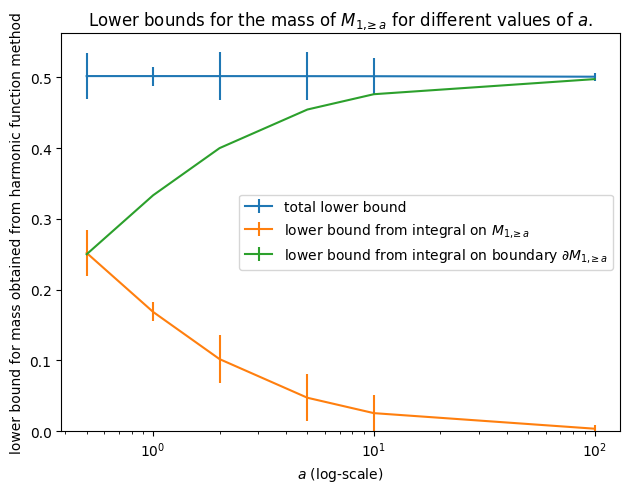

In [81]:
plt.errorbar(a_values,total_lower_bounds,yerr=total_errors,label=f"total lower bound")
plt.errorbar(a_values,lower_bounds_M,yerr=errors_M,label=f"lower bound from integral on $ M_{{{m_value},\!\!\geq a}}$")
plt.errorbar(a_values,lower_bounds_boundary,yerr=errors_boundary,label=f"lower bound from integral on boundary $\partial M_{{{m_value},\!\!\geq a}}$")
plt.xscale('log')
plt.gca().set_ylim(bottom=0)
plt.xlabel("$a$ (log-scale)")
plt.ylabel("lower bound for mass obtained from harmonic function method")
plt.legend()
plt.tight_layout()
plt.title(f"Lower bounds for the mass of $M_{{{m_value},\!\!\geq a}}$ for different values of $a$.")
plt.savefig("../figures/lower_bounds_for_different_values_of_a",bbox_inches='tight')

## Plotting the harmonic coordinates

### Plotting Utilities

Matplotlib does not come with a method of plotting implicit surfaces. The following approach is from [answers to this Stack Overflow question](https://stackoverflow.com/questions/4680525/plotting-implicit-equations-in-3d).

In [82]:
# https://stackoverflow.com/a/4687582
def plot_implicit_using_contours(ax,fn,level_set_value=0, bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50,samples=30):
    """ Create a plot of a 2d implicite surface fn(x,y,z)=level_set_value using contours

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
        samples (int, optional): Number of slices to take
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin, xmax, resolution)
    yl = np.linspace(ymin,ymax,resolution)
    zl = np.linspace(zmin, zmax, samples)
    A1, A2 = np.meshgrid(xl,xl)

    for z in zl: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z)-level_set_value
        cset = ax.contour(X, Y, Z+z-level_set_value, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z

    for y in zl: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z)-level_set_value
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    for x in zl: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z)-level_set_value
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

def plot_implicit_using_marching_cubes(ax,fn,level_set_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
    """ Create a plot of a 2d implicit surface fn(x,y,z)=level_set_value using marching cubes

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin,xmax, resolution)
    yl = np.linspace(ymin,ymax, resolution)
    zl = np.linspace(zmin,zmax, resolution)
    X, Y, Z = np.meshgrid(xl, yl, zl)
    F=fn(X,Y,Z)


    verts, faces, normals, values = measure.marching_cubes(F, level_set_value, spacing=[np.diff(xl)[0],np.diff(yl)[0],np.diff(zl)[0]])
    # need to correct vertex coordinates as they are expressed in Voxel coordinates
    verts += (xmin,ymin,zmin)
    
    ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, 
                    verts[:, 2], # color
                    cmap='jet')
    
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)
    return verts, faces

In [83]:
def plot_coordinate_level_sets(coordinate,level_set_values=(0),m_value=1,a_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
  fn = sympy.lambdify([x1,x2,x3],(coordinate()).subs(((m,m_value),(a,a_value))))

  n_plots = len(level_set_values)
  n_cols = min(2,n_plots)
  n_rows = (n_plots+1)//2

  fig = plt.figure(figsize=(10,n_rows*4+1))
  fig.suptitle(f"Level sets of ${sympy.latex(coordinate.symbol)}$ on $M_{{{m_value},\!\!\geq {a_value}}}$",fontsize=20,y=0,va="top")

  axes = fig.subplots(ncols=n_cols,nrows=n_rows,subplot_kw=dict(projection='3d'),squeeze=False)

  if n_plots<n_rows*2:
    fig.delaxes(axes[n_rows-1,n_cols-1]) # delete last axis if unneccessary

  for index, level_set_value in enumerate(level_set_values):
    ax = axes.flatten()[index]
    ax.set_title(f"${sympy.latex(coordinate.symbol)}={level_set_value:.1f}$",fontsize=16,pad=0)
    ax.locator_params(nbins=4)
    
    plot_implicit_using_marching_cubes(ax,fn,level_set_value,bbox=bbox,resolution=resolution)
  fig.tight_layout(h_pad=5)
  return fig

### Plots for $M_{m,+}=M_{m,\geq 0}$

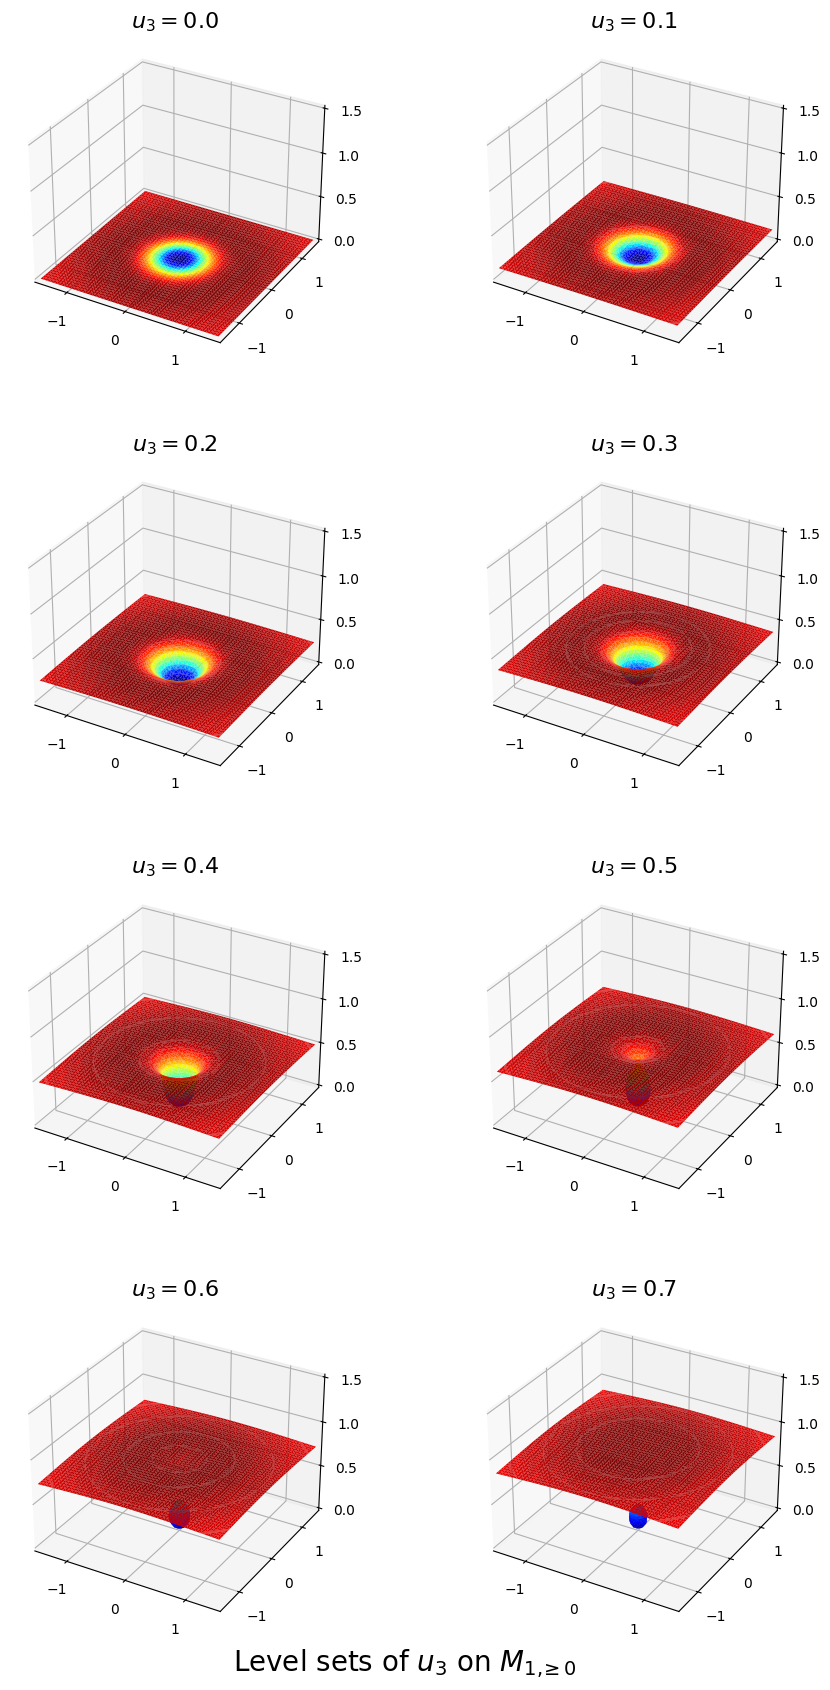

In [84]:
fig=plot_coordinate_level_sets(u3,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],bbox=[(-1.5,1.5),(-1.5,1.5),(0,1.5)])
fig.savefig("../figures/level_sets_u3_unmodified",bbox_inches='tight')

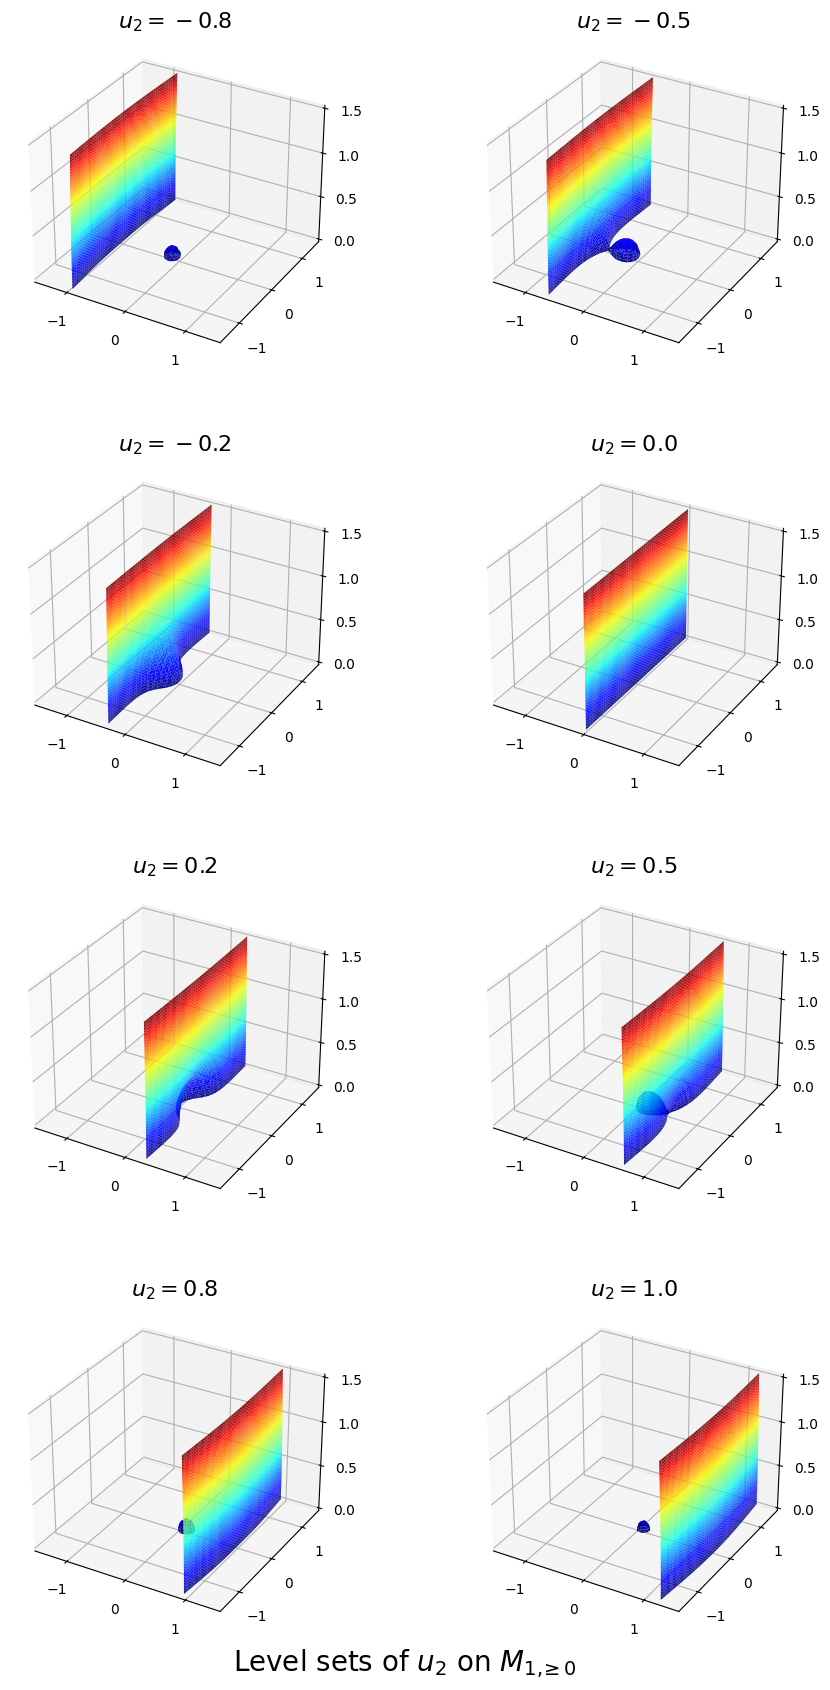

In [85]:
plot_coordinate_level_sets(u2,[-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1.0],bbox=[(-1.5,1.5),(-1.5,1.5),(0,1.5)])
plt.savefig("../figures/level_sets_u2_unmodified",bbox_inches="tight")

### Plots for $M_{m,\!\!\geq a}$. We can symbolically check that the boundary $x_3=a$ is actually a level set. Numerically this level set is not quite correctly computed due to rounding errors. 

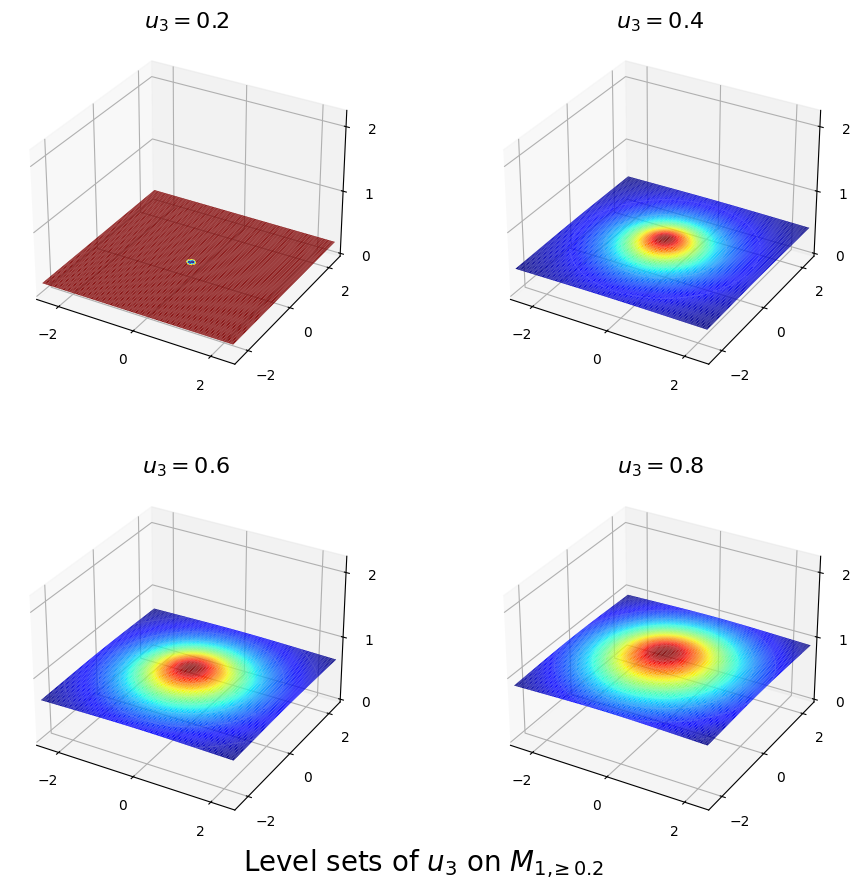

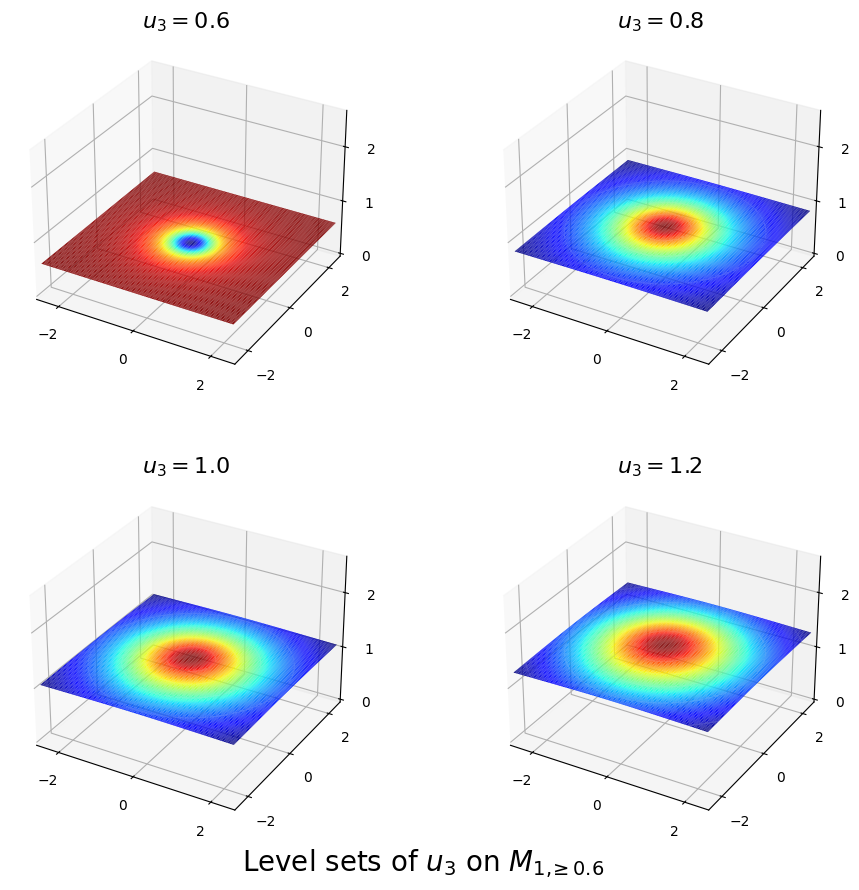

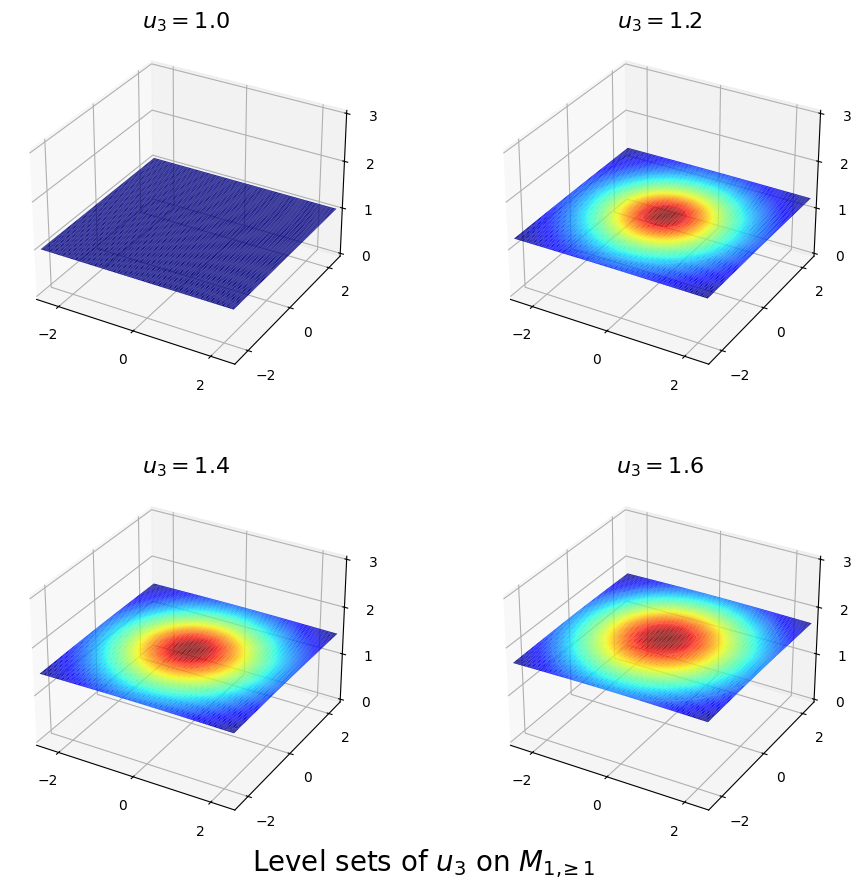

In [86]:
for a_value in [0.2,0.6,1]:
  fig=plot_coordinate_level_sets(u3_modified,np.array([0,0.2,0.4,0.6])+a_value,a_value=a_value,bbox=[(-2.5,2.5),(-2.5,2.5),(0,a_value+2)],resolution=100)
  fig.savefig(f'../figures/level_sets_u3_modified_with_a_{a_value}.png',bbox_inches='tight')